In [2]:
# load libraries and scripts
include("../scripts/tools.jl")
include("../scripts/plotting.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl");
include("../scripts/ps_analysis.jl");

In [3]:
#load borders
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
Nx, Ny, coord, isinside, isborder, isgrid, n = get_grid(border, dx);

In [125]:
# compute or load grid parameters
minv, gamma, p, xi, bx, by, m, d = get_params(isinside, isgrid, n, Ny, Nx, Float64(dx), coord,
    scale_factor, "../data/disc/pantagruel.h5",
    "../numerics/grid_params_" * string(dx) * ".h5",
    Niter=10, dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);

  2.418311 seconds (483.40 k allocations: 16.843 GiB, 9.02% gc time)
  0.893487 seconds (3.81 k allocations: 1.011 GiB, 1.33% gc time)


In [126]:
p2 = zeros(size(isgrid))
p2[isgrid] .= p
#heatmap(reshape(p2, Ny, Nx))

14597-element view(::Vector{Float64}, [323, 324, 325, 326, 333, 334, 335, 336, 337, 475  …  30672, 30673, 30822, 30823, 30824, 30825, 30826, 30976, 30977, 30978]) with eltype Float64:
   -114.63973447711308
   1053.3193151631276
   2874.316226201037
   4563.2161823527595
  -7257.72277232641
  -9160.73747067731
 -11249.919152426928
 -12670.66840316224
 -13105.771139492606
  -1419.1876738259314
   -463.2658741082437
   1142.7461185731286
   3494.1990988744483
      ⋮
  -1112.4728067507458
  -1055.3708670047142
  -1083.3655037957756
  -1136.2064979022093
  -1027.8948967110084
   -931.5824621967184
   -929.2168282210001
   -988.10771350009
  -1091.837130974515
   -795.7814169008761
   -820.3131395556211
   -860.3061157914567

In [127]:
dxi, db = add_db(isinside, isgrid, Ny, Nx, coord[isgrid,:], [-0.32; 0.22], 100.0, 0.3, dx);

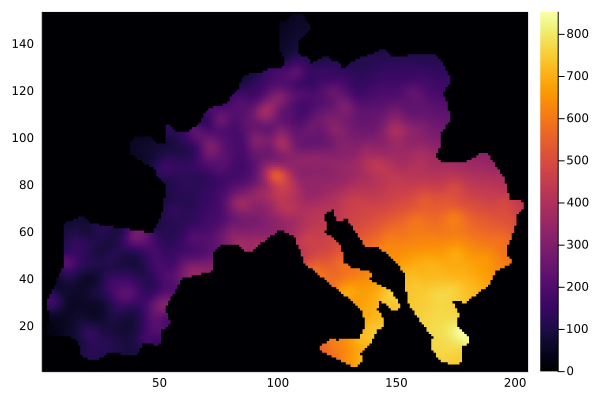

In [128]:
heatmap(reshape(bx+db,Ny,Nx))
#size(bx)
#size(by)
#plot(border[:,1], border[:,2])

In [129]:
th0 = compute_stable_sol(isinside, n, bx, by, p, interval = 10000, Niter = 60000, tol = 1e-7);

[10000.0 9.135703860829736e-5]
[20000.0 1.946704985944514e-5]
[30000.0 1.2031767859022047e-5]
[40000.0 7.510960145062917e-6]
[50000.0 4.915702041863312e-6]
[60000.0 3.2922873969276623e-6]
  6.016114 seconds (481.28 k allocations: 19.600 GiB, 6.02% gc time)


In [130]:
gen, dem, bline, idb, idgen, coord_disc, mg, dg, dl, th_ref = load_discrete_model("../data/disc/pantagruel.h5", scale_factor)
th = set_ref_phase(isgrid, coord[isgrid,:], th0, vec(coord_disc[1,:]), th_ref = 0.0)
th_disc = get_discrete_values(coord[isgrid,:], coord_disc, th0[isgrid]);

In [141]:
scatter(th_ref, th_disc)
th_min = minimum(th_ref)
th_max = maximum(th_ref)
plot!([th_min; th_max], [th_min; th_max], xlabel="\$\\theta_i^{\\rm ref}\$",
    ylabel="\$\\theta_i\$",color=:red, lw = 2, legend=false, size=(400,400), xlim=(-1.6,1.6), ylim=(-1.6, 1.6))
savefig("theta_ref_vs_cont.pdf")

In [132]:
thr = get_cont_values(isgrid, coord[isgrid,:], coord_disc, th_ref);

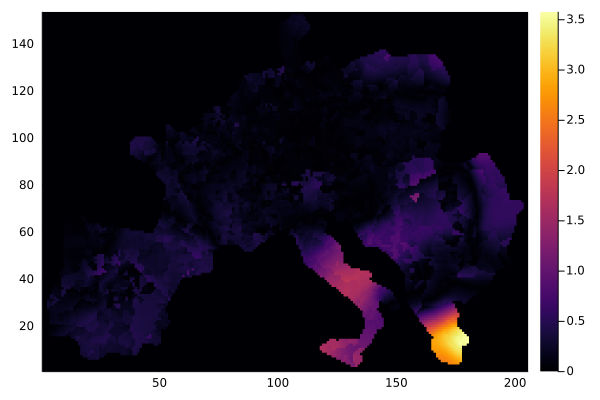

In [133]:
heatmap(reshape(abs.(thr-th), Ny, Nx))

In [134]:
disc_plot(coord_disc, th_ref)
savefig("disc_th.pdf")
#plot!(colorbar=true)
#plot!(clims=(0.0,1.0), c=:viridis, colorbar_title="cbar", grid=false)

In [135]:
hm_plot(isgrid, Ny, Nx, th, cb_title = "\$\\theta(x)\$")
savefig("cont_theta.svg")
#plot!(clims=(0.0,1.0), c=:viridis, colorbar_title="cbar", grid=false)

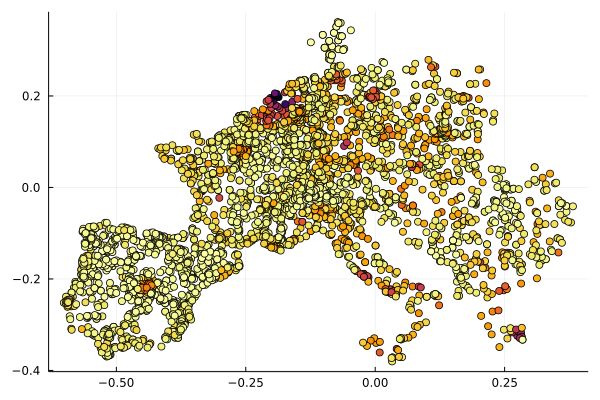

In [136]:
p = -copy(dem)
#p[idgen] += gen

disc_plot(coord_disc, p)